# Libraries

In [1]:
!pip install kaggler

     |████████████████████████████████| 818 kB 1.3 MB/s 
  Created wheel for kaggler: filename=Kaggler-0.8.13-cp37-cp37m-linux_x86_64.whl size=2136988 sha256=f4c5a92ad6be5042806156817d9bc0adb9e69e5dcf32282e3e673408f493f78c
  Stored in directory: /root/.cache/pip/wheels/7b/86/67/f26c540f45ad37dde626e6dae72e56701a0b7ab7e1999cbe5e
Successfully built kaggler


In [2]:
import pandas as pd
import numpy as np
import random
import os

from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold

import lightgbm as lgb
import catboost as ctb
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier, export_graphviz

import graphviz
import matplotlib.pyplot as plt
import seaborn as sns

from kaggler.preprocessing import LabelEncoder
from xgboost import XGBClassifier

import warnings
warnings.simplefilter('ignore')

In [3]:
TARGET = 'Survived'

N_ESTIMATORS = 1000
N_SPLITS = 10
SEED = 2021
EARLY_STOPPING_ROUNDS = 100
VERBOSE = 100

In [4]:
def set_seed(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    
set_seed(SEED)

# Load data

In [5]:
train_df = pd.read_csv('../input/tabular-playground-series-apr-2021/train.csv')
test_df = pd.read_csv('../input/tabular-playground-series-apr-2021/test.csv')
submission = pd.read_csv('../input/tabular-playground-series-apr-2021/sample_submission.csv')
test_df[TARGET] = pd.read_csv("../input/tps-apr-2021-label/pseudo_label.csv")[TARGET]

df = pd.concat([train_df, test_df]).reset_index(drop=True)

# Filling missing values

In [6]:

df['Embarked'] = df['Embarked'].fillna('No')
df['Cabin'] = df['Cabin'].fillna('_')
df['CabinType'] = df['Cabin'].apply(lambda x:x[0])
df.Ticket = df.Ticket.map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

df['Age'].fillna(round(df['Age'].median()), inplace=True,)
df['Age'] = df['Age'].apply(round).astype(int)

df['Fare'].fillna(round(df['Fare'].median()), inplace=True,)

df['FirstName'] = df['Name'].str.split(', ').str[0]
df['SecondName'] = df['Name'].str.split(', ').str[1]

df['n'] = 1

gb = df.groupby('FirstName')
df_names = gb['n'].sum()
df['SameFirstName'] = df['FirstName'].apply(lambda x:df_names[x])

gb = df.groupby('SecondName')
df_names = gb['n'].sum()
df['SameSecondName'] = df['SecondName'].apply(lambda x:df_names[x])

df['Sex'] = (df['Sex'] == 'male').astype(int)

df['FamilySize'] = df.SibSp + df.Parch + 1

feature_cols = ['Pclass', 'Age','Embarked','Parch','SibSp','Fare','CabinType','Ticket','SameFirstName', 'SameSecondName', 'Sex',
                'FamilySize', 'FirstName', 'SecondName']
cat_cols = ['Pclass','Embarked','CabinType','Ticket', 'FirstName', 'SecondName']
num_cols = [x for x in feature_cols if x not in cat_cols]
print(len(feature_cols), len(cat_cols), len(num_cols))

14 6 8


In [7]:
for col in ['SameFirstName', 'SameSecondName', 'Fare', 'FamilySize', 'Parch', 'SibSp']:
    df[col] = np.log2(1 + df[col])
    
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

lbe = LabelEncoder(min_obs=50)
df[cat_cols] = lbe.fit_transform(df[cat_cols]).astype(int)

In [8]:
# # Age fillna with mean age for each class
# all_df['Age'] = all_df['Age'].fillna(all_df['Age'].mean())

# # Cabin, fillna with 'X' and take first letter
# all_df['Cabin'] = all_df['Cabin'].fillna('X').map(lambda x: x[0].strip())

# # Ticket, fillna with 'X', split string and take first split 
# all_df['Ticket'] = all_df['Ticket'].fillna('X').map(lambda x:str(x).split()[0] if len(str(x).split()) > 1 else 'X')

# # Fare, fillna with mean value
# fare_map = all_df[['Fare', 'Pclass']].dropna().groupby('Pclass').median().to_dict()
# all_df['Fare'] = all_df['Fare'].fillna(all_df['Pclass'].map(fare_map['Fare']))
# all_df['Fare'] = np.log1p(all_df['Fare'])

# # Embarked, fillna with 'X' value
# all_df['Embarked'] = all_df['Embarked'].fillna('X')

# # Name, take only surnames
# all_df['Name'] = all_df['Name'].map(lambda x: x.split(',')[0])

# Encoding

In [9]:
# label_cols = ['Name']
# onehot_cols = ['Cabin']
# numerical_cols = ['Pclass', 'Age', 'SibSp', 'Parch', 'Fare']

In [10]:
# def label_encoder(c):
#     le = LabelEncoder()
#     return le.fit_transform(c)

# scaler = StandardScaler()

# onehot_encoded_df = pd.get_dummies(all_df[onehot_cols])
# label_encoded_df = all_df[label_cols].apply(label_encoder)
# numerical_df = pd.DataFrame(scaler.fit_transform(all_df[numerical_cols]), columns=numerical_cols)
# target_df = all_df[TARGET]

# # all_df = pd.concat([numerical_df, label_encoded_df, onehot_encoded_df, target_df], axis=1)

In [11]:
all_df = df
all_df = all_df.drop(['Name', 'PassengerId'], axis=1)


In [12]:
all_df = all_df.drop(['Cabin'], axis=1)

In [13]:
all_df

,Survived,Pclass,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked,CabinType,FirstName,SecondName,n,SameFirstName,SameSecondName,FamilySize
0,1,1,0.767417,-0.202735,2.024581,-0.582112,1,0.134444,0,1,0,628,1,0.196393,-1.010234,1.034039
1,0,0,0.767417,-0.202735,-0.639750,-0.582112,1,-0.533979,0,0,491,0,1,0.269642,-1.292962,-0.751193
2,0,0,0.767417,-2.080481,1.041256,1.851592,24,1.070905,0,0,123,18,1,0.864030,0.782105,1.608756
3,0,0,0.767417,-0.929604,-0.639750,-0.582112,3,-0.555655,0,0,512,1,1,0.259769,1.617216,-0.751193
4,1,0,0.767417,-0.566170,-0.639750,-0.582112,1,-1.023854,0,0,0,4,1,0.098290,1.467485,-0.751193
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199995,1,0,-1.303073,-0.445025,-0.639750,-0.582112,1,-0.787083,2,0,0,0,1,0.026440,-2.373951,-0.751193
199996,0,1,0.767417,1.493293,1.041256,-0.582112,1,1.029122,0,0,4,125,1,1.992961,0.042430,0.293101
199997,0,0,0.767417,0.766424,-0.639750,-0.582112,1,-0.722300,0,0,0,624,1,-0.704332,-0.999141,-0.751193
199998,1,1,-1.303073,0.887568,1.041256,1.851592,2,0.220218,1,2,0,51,1,-0.506468,0.390204,1.608756


# LightGBM

In [14]:
params = {
    'metric': 'binary_logloss',
    'n_estimators': N_ESTIMATORS,
    'objective': 'binary',
    'random_state': SEED,
    'learning_rate': 0.01,
    'min_child_samples': 150,
    'reg_alpha': 3e-5,
    'reg_lambda': 9e-2,
    'num_leaves': 20,
    'max_depth': 16,
    'colsample_bytree': 0.8,
    'subsample': 0.8,
    'subsample_freq': 2,
    'max_bin': 240,
}

In [15]:
lgb_oof = np.zeros(train_df.shape[0])
lgb_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    pre_model = lgb.LGBMRegressor(**params)
    pre_model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE
    )

    params2 = params.copy()
    params2['learning_rate'] = params['learning_rate'] * 0.1
    model = lgb.LGBMRegressor(**params2)
    model.fit(
        X_train, y_train,
        eval_set=[(X_train, y_train),(X_valid, y_valid)],
        early_stopping_rounds=EARLY_STOPPING_ROUNDS,
        verbose=VERBOSE,
        init_model=pre_model
    )
    
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = model.feature_name_
    fi_tmp["importance"] = model.feature_importances_
    fi_tmp["fold"] = fold
    fi_tmp["seed"] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    lgb_oof[oof_idx] = model.predict(X_valid)
    lgb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(lgb_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(lgb_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.408055	valid_1's binary_logloss: 0.513247
[200]	training's binary_logloss: 0.342271	valid_1's binary_logloss: 0.492827
Early stopping, best iteration is:
[197]	training's binary_logloss: 0.343498	valid_1's binary_logloss: 0.492754
Training until validation scores don't improve for 100 rounds
[200]	training's binary_logloss: 0.343397	valid_1's binary_logloss: 0.49275
[300]	training's binary_logloss: 0.339913	valid_1's binary_logloss: 0.492794
Early stopping, best iteration is:
[230]	training's binary_logloss: 0.342303	valid_1's binary_logloss: 0.49272
===== ACCURACY SCORE 0.773906 =====

===== FOLD 1 =====
Training until validation scores don't improve for 100 rounds
[100]	training's binary_logloss: 0.40848	valid_1's binary_logloss: 0.511615
[200]	training's binary_logloss: 0.342903	valid_1's binary_logloss: 0.490253
[300]	training's binary_logloss: 0.320861	valid_1's bina

### Feature importance

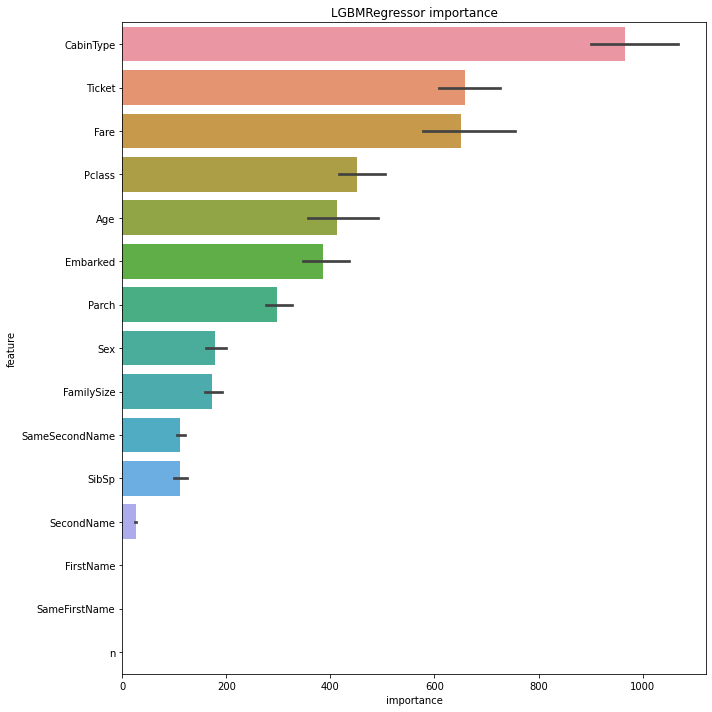

In [16]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("LGBMRegressor"))
plt.tight_layout()

# CatBoost

In [17]:
params = {
    'bootstrap_type': 'Poisson',
    'loss_function': 'Logloss',
    'eval_metric': 'Logloss',
    'random_seed': SEED,
    'task_type': 'GPU',
    'max_depth': 8,
    'learning_rate': 0.01,
    'n_estimators': N_ESTIMATORS,
    'max_bin': 280,
    'min_data_in_leaf': 64,
    'l2_leaf_reg': 0.01,
    'subsample': 0.8
}

In [18]:
ctb_oof = np.zeros(train_df.shape[0])
ctb_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    model = ctb.CatBoostClassifier(**params)
    model.fit(X_train, y_train,
              eval_set=[(X_valid, y_valid)],
              use_best_model=True,
              early_stopping_rounds=EARLY_STOPPING_ROUNDS,
              verbose=VERBOSE
              )
    
    fi_tmp = pd.DataFrame()
    fi_tmp["feature"] = X_test.columns.to_list()
    fi_tmp["importance"] = model.get_feature_importance()
    fi_tmp["fold"] = fold
    fi_tmp["seed"] = SEED
    feature_importances = feature_importances.append(fi_tmp)
    
    ctb_oof[oof_idx] = model.predict(X_valid)
    ctb_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(ctb_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(ctb_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
0:	learn: 0.6836760	test: 0.6866686	best: 0.6866686 (0)	total: 28.1ms	remaining: 28s
100:	learn: 0.3529370	test: 0.4956800	best: 0.4956800 (100)	total: 1.38s	remaining: 12.2s
200:	learn: 0.3170473	test: 0.4996252	best: 0.4946672 (120)	total: 2.7s	remaining: 10.7s
bestTest = 0.494667236
bestIteration = 120
Shrink model to first 121 iterations.
===== ACCURACY SCORE 0.772223 =====

===== FOLD 1 =====
0:	learn: 0.6837025	test: 0.6866196	best: 0.6866196 (0)	total: 14.3ms	remaining: 14.3s
100:	learn: 0.3534344	test: 0.4921121	best: 0.4921121 (100)	total: 1.34s	remaining: 11.9s
200:	learn: 0.3177498	test: 0.4942080	best: 0.4905940 (126)	total: 3.1s	remaining: 12.3s
bestTest = 0.4905940421
bestIteration = 126
Shrink model to first 127 iterations.
===== ACCURACY SCORE 0.776300 =====

===== FOLD 2 =====
0:	learn: 0.6836740	test: 0.6866715	best: 0.6866715 (0)	total: 14.5ms	remaining: 14.5s
100:	learn: 0.3526300	test: 0.5000094	best: 0.5000094 (100)	total: 1.45s	remaining: 12.9s

### Feature importance

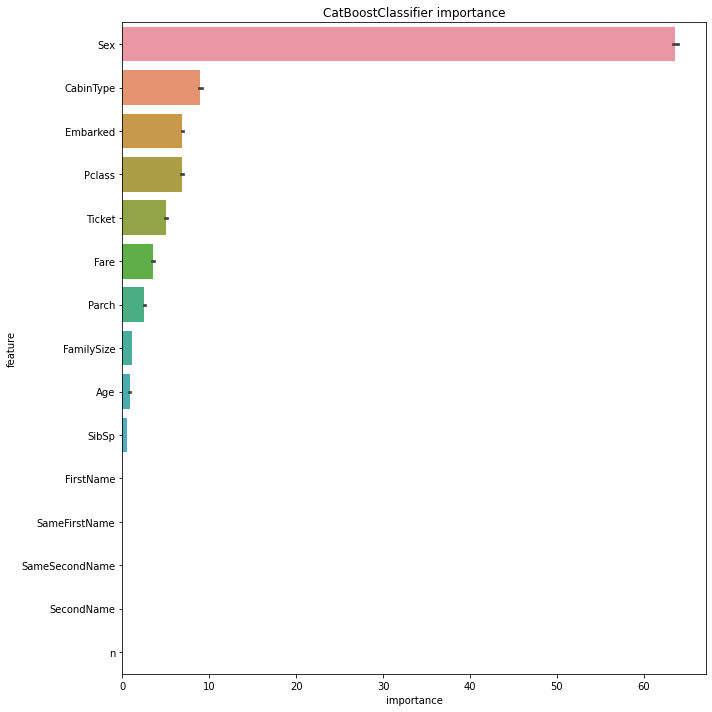

In [19]:
# just to get ideas to improve
order = list(feature_importances.groupby("feature").mean().sort_values("importance", ascending=False).index)
plt.figure(figsize=(10, 10))
sns.barplot(x="importance", y="feature", data=feature_importances, order=order)
plt.title("{} importance".format("CatBoostClassifier"))
plt.tight_layout()

# DecisionTreeModel

In [20]:
# # Tuning the DecisionTreeClassifier by the GridSearchCV
# parameters = {
#     'max_depth': np.arange(2, 5, dtype=int),
#     'min_samples_leaf':  np.arange(2, 5, dtype=int)
# }

# classifier = DecisionTreeClassifier(random_state=2021)

# model = GridSearchCV(
#     estimator=classifier,
#     param_grid=parameters,
#     scoring='accuracy',
#     cv=10,
#     n_jobs=-1)
# model.fit(X_train, y_train)

# best_parameters = model.best_params_
# print(best_parameters)

In [21]:
dtm_oof = np.zeros(train_df.shape[0])
dtm_preds = np.zeros(test_df.shape[0])
feature_importances = pd.DataFrame()

skf = StratifiedKFold(n_splits=N_SPLITS, shuffle=True, random_state=SEED)

for fold, (train_idx, valid_idx) in enumerate(skf.split(all_df, all_df[TARGET])):
    print(f"===== FOLD {fold} =====")
    oof_idx = np.array([idx for idx in valid_idx if idx < train_df.shape[0]])
    preds_idx = np.array([idx for idx in valid_idx if idx >= train_df.shape[0]])

    X_train, y_train = all_df.iloc[train_idx].drop(TARGET, axis=1), all_df.iloc[train_idx][TARGET]
    X_valid, y_valid = all_df.iloc[oof_idx].drop(TARGET, axis=1), all_df.iloc[oof_idx][TARGET]
    X_test = all_df.iloc[preds_idx].drop(TARGET, axis=1)
    
    model = XGBClassifier(tree_method = 'gpu_hist',learning_rate=0.01, max_depth=10, min_child_weight=17, n_estimators=100, n_jobs=1, subsample=1.0, verbosity=0)
    model.fit(X_train, y_train)
    
    dtm_oof[oof_idx] = model.predict(X_valid)
    dtm_preds[preds_idx-train_df.shape[0]] = model.predict(X_test)
    
    acc_score = accuracy_score(y_valid, np.where(dtm_oof[oof_idx]>0.5, 1, 0))
    print(f"===== ACCURACY SCORE {acc_score:.6f} =====\n")
    
acc_score = accuracy_score(all_df[:train_df.shape[0]][TARGET], np.where(dtm_oof>0.5, 1, 0))
print(f"===== ACCURACY SCORE {acc_score:.6f} =====")

===== FOLD 0 =====
===== ACCURACY SCORE 0.776777 =====

===== FOLD 1 =====
===== ACCURACY SCORE 0.777811 =====

===== FOLD 2 =====
===== ACCURACY SCORE 0.774885 =====

===== FOLD 3 =====
===== ACCURACY SCORE 0.779958 =====

===== FOLD 4 =====
===== ACCURACY SCORE 0.770927 =====

===== FOLD 5 =====
===== ACCURACY SCORE 0.778513 =====

===== FOLD 6 =====
===== ACCURACY SCORE 0.779178 =====

===== FOLD 7 =====
===== ACCURACY SCORE 0.776487 =====

===== FOLD 8 =====
===== ACCURACY SCORE 0.781710 =====

===== FOLD 9 =====
===== ACCURACY SCORE 0.786964 =====

===== ACCURACY SCORE 0.778320 =====


### Plot tree

In [22]:
# # plot tree
# dot_data = export_graphviz(
#     model,
#     out_file=None,
#     feature_names=X_train.columns,
#     class_names=['0', '1'],
#     filled=True,
#     rounded=False,
#     special_characters=True,
#     precision=3
# )
# graph = graphviz.Source(dot_data)
# graph 

# Ensemble

In [23]:
bound_1 = pd.Series(lgb_preds).sort_values(ascending = False).head(34911).values[-1]

In [24]:
submission['submit_lgb'] = (lgb_preds>bound_1).astype(int)
submission['submit_ctb'] = pd.Series(ctb_preds).astype(int)
submission['submit_dtm'] = pd.Series(dtm_preds).astype(int)

In [25]:
submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    64925
3    33877
1      621
2      577
dtype: int64

In [26]:
submission[TARGET] = (submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)
submission.drop([col for col in submission.columns if col.startswith('submit_')], axis=1, inplace=True)

# Ensemble/Submission

In [27]:
submission.to_csv('LCX_without_ensemble.csv', index=False)

In [28]:
submission['submit_1'] = submission[TARGET].copy()
submission['submit_2'] = pd.read_csv("../input/tps-apr-2021-pseudo-labeling-voting-ensemble-edit/scoring_edit.csv")[TARGET]
submission['submit_3'] = pd.read_csv("../input/tps-apr-2021-label/pseudo_label.csv")[TARGET]


FileNotFoundError: [Errno 2] No such file or directory: '../input/tps-apr-2021-pseudo-labeling-voting-ensemble-edit/scoring_edit.csv'

In [29]:
submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis = 1).value_counts()

0    65546
1    34454
dtype: int64

In [30]:
submission[TARGET] = (submission[[col for col in submission.columns if col.startswith('submit_')]].sum(axis=1) >= 2).astype(int)

In [31]:
submission[['PassengerId', TARGET]].to_csv("LCX_with_ensemble.csv", index = False)

<AxesSubplot:>

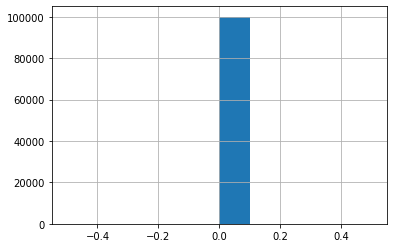

In [32]:
submission[TARGET].hist()